# Viewtime and conversion to UTC
This notebook demonstrates the process of:

- Accessing the viewtime asset from the coarse resolution fusion input
- Converting the viewtime in local solar time to UTC

We'll start with the necessary inputs.

In [1]:
import json
import requests
import pystac
from pystac_client import Client

from shapely.geometry import Point
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import base64

from FH_Hydrosat import FH_Hydrosat
from datetime import datetime as DT
import datetime as DT

The next few cells will execute the STAC search as usual. In this case, we'll get the MOD21A1D coarse resolution fusion input as well as the HDST products.

In [2]:
with open('creds.json') as f:
    creds = json.loads(f.read())

In [3]:
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

In [4]:
geom = {'type': 'Point', 'coordinates': [-120.21102905273436,36.535019209789]} # Point for Hanford, CA, USA

start_date = "2021-08-17T00:00:00Z"
end_date = "2021-08-30T00:00:00Z"

search = catalog.search(
    collections = ["prepped_inputs_mod21a1d"], #The coarse resolution MOD21A1D LST input to fusion
    intersects = geom,
    datetime = [start_date, end_date],
    max_items = 500
)
# mod_items = list(search.items()) # for pystac-client >= 0.4.0
mod_items = list(search.get_all_items()) # for pystac-client < 0.4.0
mod_items.reverse() # make the results ascending in time

search = catalog.search(
    collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"], # The HDST products
    intersects = geom,
    datetime = [start_date, end_date],
    max_items = 500
)


# hdst_items = list(search.items()) # for pystac-client >= 0.4.0
hdst_items = list(search.get_all_items()) # for pystac-client < 0.4.0
hdst_items.reverse() # make the results ascending in time
print(len(mod_items))
print(len(hdst_items))

14
13


In [5]:
mgrs_tiles = []
for i in hdst_items:
    for l in i.to_dict()['links']:
        if 'element84' in l['href']:
            mgrs_tiles.append(l['href'].split(r'/')[-1].split('_')[1])
hdst_items = [i for i in hdst_items if mgrs_tiles[0] in i.id]

Next we'll use the `FH_Hydrosat` helper functions to create a list of the "viewtimes" in the timeseries for a given point geometry. These times come from the `lst_view_time` asset for MOD21A1D items.

In [6]:
pt_wgs84 = Point(geom['coordinates'][0], geom['coordinates'][1])

viewtime_res = FH_Hydrosat(mod_items, asset='lst_view_time')
viewtime_ts = viewtime_res.point_time_series_from_items(pt_wgs84, tol=2000, nproc=6)
viewtime_ts = [v*0.1 for v in viewtime_ts]

using 6 processes to sample 14 assets


In [7]:
viewtime_ts

[10.4,
 11.100000000000001,
 10.200000000000001,
 10.9,
 10.0,
 10.700000000000001,
 11.4,
 10.5,
 11.200000000000001,
 10.3,
 11.0,
 10.100000000000001,
 10.8,
 11.5]

Now we'll plot the viewtimes. These are in local solar time. You'll notice that they vary from day to day, but are generally within 1.5 hours of eachother. The viewtime can also vary across a single MOD21A1D product. For more information, see the MOD21A1D ATBD: https://lpdaac.usgs.gov/documents/1399/MOD21_ATBD.pdf

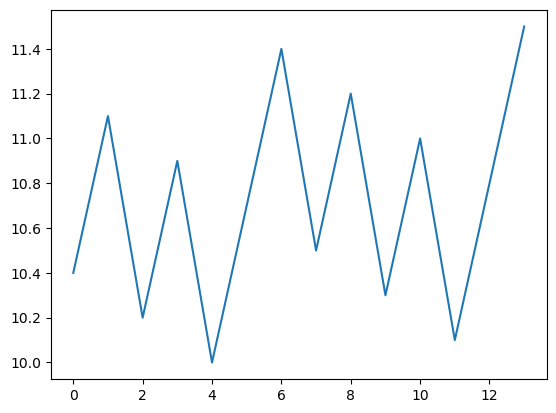

In [8]:
plt.plot(viewtime_ts)
plt.show()

Next we'll create a timeseries of LST from the HDST product for the same point.

In [9]:
lst_res = FH_Hydrosat(hdst_items, asset='lst')
lst_ts = lst_res.point_time_series_from_items(pt_wgs84, tol=2000, nproc=6)

using 6 processes to sample 13 assets


You'll notice that some of the HDST products only have a date and do not show a nominal observation time.

In [10]:
hdst_dt = lst_res.datetime
hdst_df = pd.DataFrame({'fused_lst': lst_ts,
                          'datetime': pd.to_datetime(hdst_dt)}).sort_values(by='datetime')
hdst_df['fused_lst'] = hdst_df['fused_lst'].astype(float)

hdst_df.dropna(inplace=True)
hdst_df

,fused_lst,datetime
0,319.647186,2021-08-17 00:00:00+00:00
1,311.785156,2021-08-18 00:00:00+00:00
2,301.110474,2021-08-19 00:00:00+00:00
3,309.528900,2021-08-20 00:00:00+00:00
4,309.813385,2021-08-21 18:40:04.472248+00:00
5,317.071136,2021-08-22 00:00:00+00:00
6,318.495239,2021-08-23 00:00:00+00:00
7,317.482910,2021-08-24 00:00:00+00:00
8,316.709290,2021-08-25 00:00:00+00:00
9,317.916840,2021-08-26 00:00:00+00:00


We can derive the nominal observation time by using the viewtime (local solar time) from the coarse resolution assets above and converting it to UTC.

In [11]:
# adjust the datetime
viewtime_ts = [x for x in viewtime_ts if str(x) != 'nan']
local_solar_time = []
data_type = []
for x,dt in zip(viewtime_ts, hdst_df['datetime']):
    if '00:00:00' in str(dt):
        local_solar_time.append(dt + DT.timedelta(seconds=x*60*60.0))
        data_type.append('fused')
    else:
        local_solar_time.append(dt)
        data_type.append('landsat')
#local_solar_time = [dt + DT.timedelta(seconds=x*60*60.0) if '00:00:00' in str(dt) else dt for x,dt in zip(viewtime_ts, hdst_df['datetime'])]

# adjust for longitude and UTC if not associated with landsat
pt_lon = geom['coordinates'][0]
pt_utc_offset = -pt_lon/15
pt_utc = []
for dt, _type in zip(local_solar_time, data_type):
    if _type == 'landsat':
        pt_utc.append(dt)
    else:
        pt_utc.append(dt + DT.timedelta(seconds=pt_utc_offset*60*60.0))
#pt_utc = [dt + DT.timedelta(seconds=pt_utc_offset*60*60.0) for dt in local_solar_time]

# pv equations for site
gmt_offset = 8
d = np.array([d.timetuple().tm_yday for d in hdst_df['datetime']])
B = (360/365)*(d-81)
EoT = 9.87*np.sin(np.deg2rad(2*B)) - 7.53*np.cos(np.deg2rad(B)) - 1.5*np.sin(np.deg2rad(B))
TC = 4*(pt_lon + gmt_offset*15) + EoT

LT = []
for _dtz, _tc, _type in zip(local_solar_time, TC, data_type):
    if _type == 'landsat':
        LT.append(_dtz)
    else:
        LT.append(_dtz - DT.timedelta(hours=_tc/60) + DT.timedelta(hours=gmt_offset))
# LT = [_dtz - DT.timedelta(hours=_tc/60) + DT.timedelta(hours=gmt_offset) for _dtz, _tc in zip(hdst_df['datetime'], TC)]


hdst_df['UTC_time'] = LT
hdst_df

,fused_lst,datetime,UTC_time
0,319.647186,2021-08-17 00:00:00+00:00,2021-08-17 18:28:35.861866+00:00
1,311.785156,2021-08-18 00:00:00+00:00,2021-08-18 19:10:22.330436+00:00
2,301.110474,2021-08-19 00:00:00+00:00,2021-08-19 18:16:08.255089+00:00
3,309.528900,2021-08-20 00:00:00+00:00,2021-08-20 18:57:53.647627+00:00
4,309.813385,2021-08-21 18:40:04.472248+00:00,2021-08-21 18:40:04.472248+00:00
5,317.071136,2021-08-22 00:00:00+00:00,2021-08-22 18:45:22.887148+00:00
6,318.495239,2021-08-23 00:00:00+00:00,2021-08-23 19:27:06.761276+00:00
7,317.482910,2021-08-24 00:00:00+00:00,2021-08-24 18:32:50.157547+00:00
8,316.709290,2021-08-25 00:00:00+00:00,2021-08-25 19:14:33.091216+00:00
9,317.916840,2021-08-26 00:00:00+00:00,2021-08-26 18:20:15.578181+00:00
